# Data Exploration

In this noteboook we explore through the data by Exploratory Analysis, Feature engineering columns, and One Hot Encode before our modeling

In [1]:
# import libraries

import pandas as pd
import numpy as np
import math as m
from ast import literal_eval
import itertools
import re


from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (VotingClassifier, 
                              RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              BaggingClassifier
                             )
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import ClusterCentroids
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             recall_score, 
                             precision_score,
                             precision_recall_curve,
                             make_scorer,
                             confusion_matrix,
                             plot_confusion_matrix,
                             plot_roc_curve,
                             classification_report,
                             roc_curve,
                             auc,
                             plot_precision_recall_curve,
                             roc_auc_score,
                             log_loss
                             
                             
)
# For plotting the tree.
from sklearn.tree import export_graphviz, plot_tree
# from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

import joblib
import xgboost as xgb
from xgboost import plot_importance

## Import

In [2]:
df = pd.read_csv('data/steam_clean.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5489 entries, 0 to 5488
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  5489 non-null   object 
 1   name                  5489 non-null   object 
 2   appid                 5489 non-null   int64  
 3   required_age          5489 non-null   float64
 4   is_free               5489 non-null   bool   
 5   detailed_description  5489 non-null   object 
 6   about_the_game        5489 non-null   object 
 7   short_description     5489 non-null   object 
 8   linux_requirements    5489 non-null   object 
 9   price_overview        4232 non-null   object 
 10  platforms             5489 non-null   object 
 11  categories            5489 non-null   object 
 12  achievements          4989 non-null   object 
 13  release_date          5489 non-null   object 
 14  developer             5489 non-null   object 
 15  publisher            

## Preprocess & Feature Engineer

In [4]:
# Preprocessing functions

def rename_columns(df):
    """Rename columns"""
    df = df.copy()
    
    df.rename(columns = {'average_forever': 'average_playtime', 'median_forever': 'median_playtime', 
                         'positive': 'positive_ratings', 'negative': 'negative_ratings', 'owners_max': 'total_owners'}, inplace = True)
    return df
  
def required_age(df):    
    """Format age according the the US ESRB Rating Category # https://www.esrb.org/ratings-guide/"""
    # ESRB Age Rating: 1 , 10, 13, 17, 18
    cut_points = [-1, 0, 10, 13, 17, 30]
    label_values = ['All Ages', 'Young Teen Age', 'Teen Age', 'Mature Age', 'Adult Age']
    
    df['required_age'] = pd.cut(df['required_age'], bins=cut_points, labels=label_values)
    
    df['required_age'] = df['required_age'].astype('object')
    
    return df

def drop_cols(df, cols):
    """ Drop unnecessary columns """
    df = df.copy()
    
    cols = cols
    
    df.drop(columns = cols, axis = 0, inplace = True)
    
    return df



In [5]:
def feature_engineering(df):
    """ Create new columns based on the columns provided"""
    df = df.copy()
    
    df = rename_columns(df)
    df = required_age(df)
    
    # create release year column
    df['release_date'] = pd.to_datetime(df['release_date'], yearfirst = True, errors = 'coerce')
    df['release_year'] = df['release_date'].dt.year
    
    # total ratings from positive and negative ratings
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    
    # min and max revenue from price and owners
    df['max_revenue'] = df['total_owners'] * df['price']
    df['min_revenue'] = df['owners_min'] * df['price']
    
    # OHE owners over over 1mil:1 less than 1mil:0
    df['over_1mil'] = df['total_owners'].map(lambda x: 1 if x >= 1000000 else 0)
    
    # full column of all game attributes - tags_cleaned, categories, and genre
    df['game_attributes'] = df['tags_cleaned'] + '; ' + df['categories'] + '; ' + df['genre']
    
    #drop unnecessary columns
    df = drop_cols(df, cols = ['price_overview', 'achievements', 
                               'median_2weeks', 'average_2weeks', 'is_free'])
    
    
    return df

df1 = feature_engineering(df)

### Price

In [6]:
# create category column for Price that ranges from free, cheap, midrange and expensive priced games
df1['price'].quantile([1/3,2/3,1.]) #1.99, 13.99, 99.99
df1['price_range'] = pd.qcut(df1[df1.price != 0]['price'], 
                            [0., 1/3, 2/3, 1.],labels=['Cheap', 'Midrange', 'Expensive'], 
                            retbins=True)[0]

In [7]:
# create different categories for price range
df1['price_range'].cat.add_categories('Free',inplace=True)
df1['price_range'].cat.reorder_categories(['Free','Cheap', 'Midrange', 'Expensive'],inplace=True)
df1.loc[df1.price == 0, 'price_range'] = 'Free'
df1[df1.price == 0]['price_range']
df1.loc[df1.price == 0,'price_range']

14      Free
19      Free
22      Free
24      Free
25      Free
        ... 
5453    Free
5454    Free
5457    Free
5458    Free
5484    Free
Name: price_range, Length: 1340, dtype: category
Categories (4, object): ['Free' < 'Cheap' < 'Midrange' < 'Expensive']

In [8]:
df1['price_range'].value_counts()

Cheap        1397
Midrange     1379
Expensive    1373
Free         1340
Name: price_range, dtype: int64

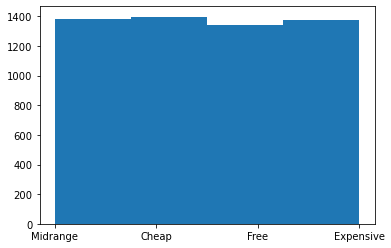

In [9]:
plt.hist(df1['price_range'], bins=4)
plt.show()

# Data Overview & Understanding

## Game Attributes to Owners Comparison

In [10]:
def fill_col(df, punc):
    """ For filling column for multilabeling"""
    df = df.str.replace(' ', '')
    col_dict = df.apply(lambda x: x.split(punc)).apply(lambda y:{values: 1 for values in y}).values
    col_fill = pd.DataFrame(list(col_dict)).fillna(0)
    return col_fill

### Genre

In [11]:
genre = fill_col(df1['genre'], ',')
genre['total_owners'] = df1['total_owners']
genre.columns
gen_cols = ['Action', 'Strategy', 'Adventure', 'Indie', 'RPG', 'Casual',
           'Racing', 'MassivelyMultiplayer', 'Sports']


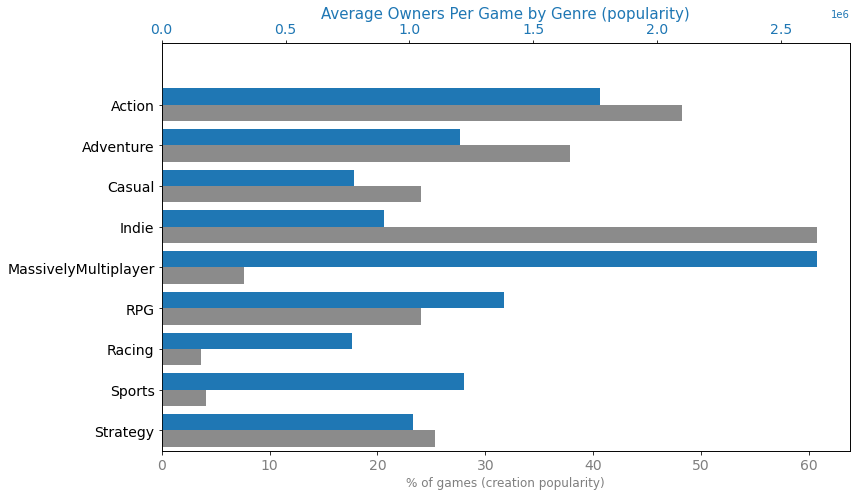

In [12]:
def plot_owners_comparison(df):
    # percentage of games in each genre
    total_owners_per_genre = df[gen_cols].multiply(df['total_owners'], axis='index').sum()
    average_owners_per_genre = total_owners_per_genre / df[gen_cols].sum()

    fig, ax1 = plt.subplots(figsize=(12,7))

    color = 'tab:gray'
    (df[gen_cols].mean() * 100).sort_index(ascending=False).plot.barh(ax=ax1, color=color, alpha=.9, position=1, fontsize=14, width=0.4)
    # ax1.set_ylabel('genre')

    ax1.set_xlabel('% of games (creation popularity)', color=color, size=12)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.tick_params(axis='y', left='off', top='off')
    # ax1.axes.get_yaxis().set_visible(False)

    ax2 = ax1.twiny()

    color = 'tab:blue'
    average_owners_per_genre.sort_index(ascending=False).plot.barh(ax=ax2, color=color, alpha=1, position=0, fontsize=14, width=0.4)
    ax2.set_xlabel('Average Owners Per Game by Genre (popularity)', color=color, size=15)
    ax2.tick_params(axis='x', labelcolor=color)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.set_ylim([-.5, 9.5])

    plt.tight_layout()
    plt.show()
    
plot_owners_comparison(genre)

Genres with the blue bar has a high number of average owners per game (consumer popularity). The noteworth genres such as Massively Multiplayer and action are highly popular in the steam market and in high demand. Meaning there are more players that are willing to play these time of games. The gray bar represents the the high creation popularity such is the proportion of games in our dataset. Games with lower creation popularity may either a very specific type of genre or have a smaller audience.

Games with a high creation popularity and low consumer popularity could represent that the genre is very over-saturated which leads to newer games with similar genres having a harder time breaking into steam's popularity list. Games genres such as Racing, RPG, sports and strategy may indicate a high possiblity for increased competition.

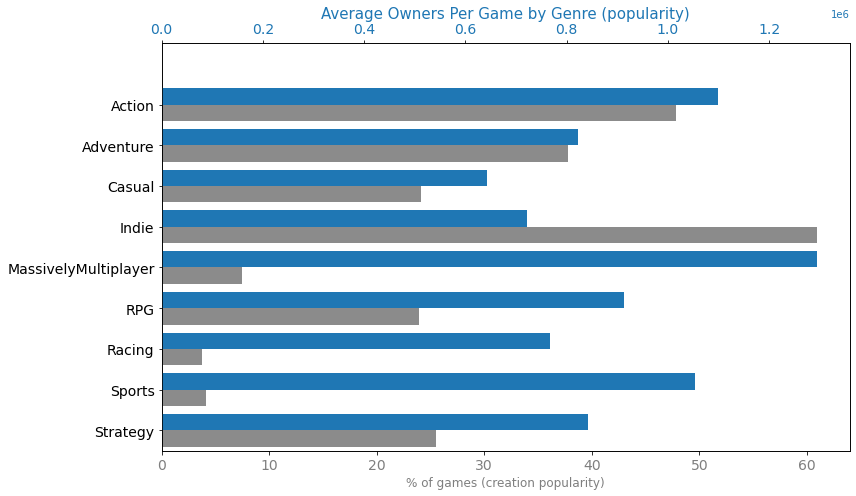

In [13]:
plot_owners_comparison(genre[genre.total_owners <= 10000000])

### Developers

In [14]:
developers = df1.groupby(['developer', 'total_owners']).sum().sort_values(by = 'total_owners', ascending=False)
developers

,,appid,positive_ratings,negative_ratings,average_playtime,median_playtime,price,initialprice,discount,ccu,review_score,rating,owners_min,multiplayer,singleplayer,release_year,total_ratings,max_revenue,min_revenue,over_1mil
developer,total_owners,,,,,,,,,,,,,,,,,,,
Valve,200000000,570,1421129,280558,35483,929,0.00,0,0,589010,0.84,84.0,100000000,1,0,2013,1701687,0.000000e+00,0.000000e+00,1
Amazon Games,100000000,1063730,151219,71007,9088,3914,39.99,3999,0,26231,0.68,68.0,50000000,0,0,2021,222226,3.999000e+09,1.999500e+09,1
"KRAFTON, Inc.",100000000,578080,1110813,876946,21824,8263,0.00,0,0,480133,0.56,56.0,50000000,1,0,2017,1987759,0.000000e+00,0.000000e+00,1
"Valve, Hidden Path Entertainment",100000000,730,5559446,743041,28940,6887,0.00,0,0,862238,0.88,88.0,50000000,1,0,2012,6302487,0.000000e+00,0.000000e+00,1
Valve,100000000,440,800161,54309,9470,406,0.00,0,0,71215,0.94,93.0,50000000,1,0,2007,854470,0.000000e+00,0.000000e+00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Psychotic Psoftware,200000,312640,149,106,401,404,2.99,299,0,1,0.58,56.0,100000,0,1,2014,255,5.980000e+05,2.990000e+05,0
Psychic Software,200000,295710,221,232,10,14,0.00,0,0,5,0.49,49.0,100000,0,0,2014,453,0.000000e+00,0.000000e+00,0
Evil Twin Artworks,200000,298480,387,137,447,877,24.99,2499,0,2,0.74,70.0,100000,0,1,2014,524,4.998000e+06,2.499000e+06,0


,games_released,over_1mil_games_owned
developer,,
Valve,29,29
id Software,18,9
Daedalic Entertainment,18,4
"CAPCOM Co., Ltd.",18,17
Square Enix,18,8
"KOEI TECMO GAMES CO., LTD.",16,7
Arc System Works,13,2
SEGA,13,3
EGAMER,13,1


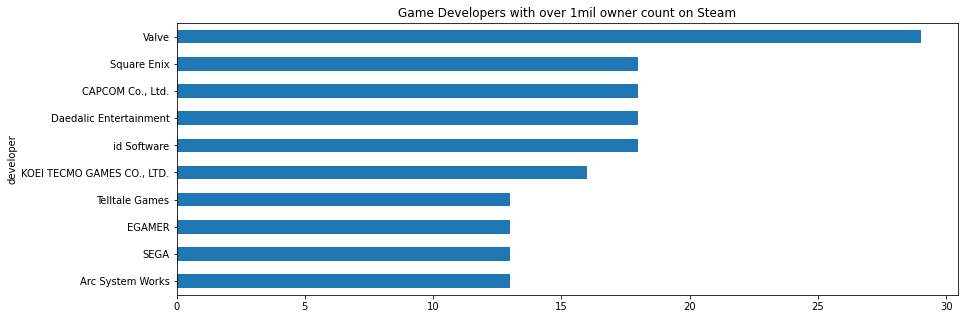

In [15]:
AMT_TO_SEE = 10
developers = pd.DataFrame(df1.loc[df1.developer != 'Unknown']['developer'])

def count_games_for_developer(value):
    return len(developers.loc[df1.developer == value])

def get_overall_target_of_developer(value):
    return df1.loc[df1.developer == value]['over_1mil'].sum()

developers['games_released'] = developers['developer'].apply(count_games_for_developer)
developers['over_1mil_games_owned'] = developers['developer'].apply(get_overall_target_of_developer)

developers = developers.drop_duplicates(subset=['developer']).reset_index().set_index('developer')
developers.drop(columns = ['index'], axis = 0, inplace=True)

developers = developers.sort_values('games_released',ascending=False)
developers.iloc[:AMT_TO_SEE]['games_released'].sort_values(ascending=True).plot(kind='barh', figsize=(14,5), 
                                                                                title = 'Game Developers with over 1mil owner count on Steam', ylabel = 'Count of Games')
developers[:AMT_TO_SEE]

As expected, since Valve has the highest count of released games and the most owners. This is from the fact that they are the developers of Steam.

In [16]:
# create separate variables for numerical and categorial columns
CAT = df1.select_dtypes(include= ['object', 'category', 'bool'])
NUM = df1.select_dtypes(include= [np.number, 'datetime64'])

In [17]:
NUM.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,appid,positive_ratings,negative_ratings,average_playtime,median_playtime,price,initialprice,discount,ccu,review_score,rating,owners_min,total_owners,multiplayer,singleplayer,release_year,total_ratings,max_revenue,min_revenue,over_1mil
count,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000,5489.00000
mean,556366.46457,11044.76389,1732.63910,804.12680,645.23010,10.79183,1129.43378,3.28056,1145.06121,0.78449,75.47805,583840.40809,1276899.25305,0.32009,0.88850,2016.06249,12777.40299,15661214.97541,7127715.79523,0.28366
std,399395.84583,88929.74369,16971.87829,3326.91208,4326.95595,12.22997,1247.07267,14.91525,18488.49471,0.16099,14.48530,2392919.45716,5069731.87386,0.46656,0.31477,3.39174,102694.44026,87172763.32838,39979467.56420,0.45081
min,10.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,100000.00000,200000.00000,0.00000,0.00000,1997.00000,0.00000,0.00000,0.00000,0.00000
25%,272470.00000,522.00000,134.00000,93.00000,68.00000,0.54000,99.00000,0.00000,1.00000,0.70000,67.00000,100000.00000,200000.00000,0.00000,1.00000,2014.00000,727.00000,198000.00000,99000.00000,0.00000
50%,437160.00000,1660.00000,318.00000,243.00000,224.00000,7.49000,999.00000,0.00000,11.00000,0.83000,79.00000,200000.00000,500000.00000,0.00000,1.00000,2016.00000,2109.00000,2495000.00000,999000.00000,0.00000
75%,773370.00000,5004.00000,867.00000,597.00000,441.00000,15.00000,1999.00000,0.00000,88.00000,0.91000,87.00000,500000.00000,1000000.00000,1.00000,1.00000,2019.00000,6068.00000,9980000.00000,3998000.00000,1.00000
max,1903490.00000,5559446.00000,876946.00000,120223.00000,225183.00000,99.99000,9999.00000,90.00000,862238.00000,1.00000,98.00000,100000000.00000,200000000.00000,1.00000,1.00000,2022.00000,6302487.00000,3999000000.00000,1999500000.00000,1.00000


### Number of Games Released

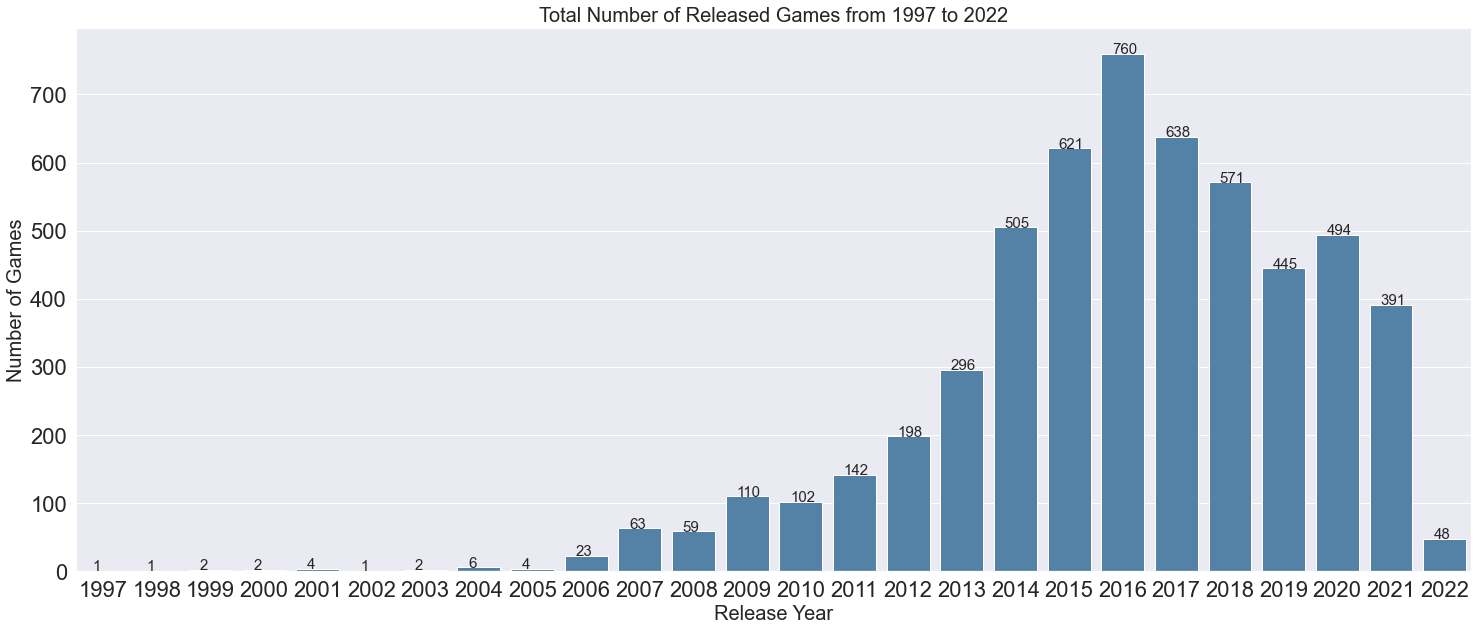

In [18]:
plt.figure(figsize=(25,10))
sns.set_theme(style = 'darkgrid', font_scale = 2)
ax = sns.countplot(x=df1['release_year'],data=df1, color= 'steelblue')
plt.title('Total Number of Released Games from 1997 to 2022', fontsize = 20)
plt.ylabel('Number of Games', fontsize = 20)
plt.xlabel('Release Year', fontsize = 20)

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), size=15)
    
plt.show()

<AxesSubplot:xlabel='total_owners', ylabel='count'>

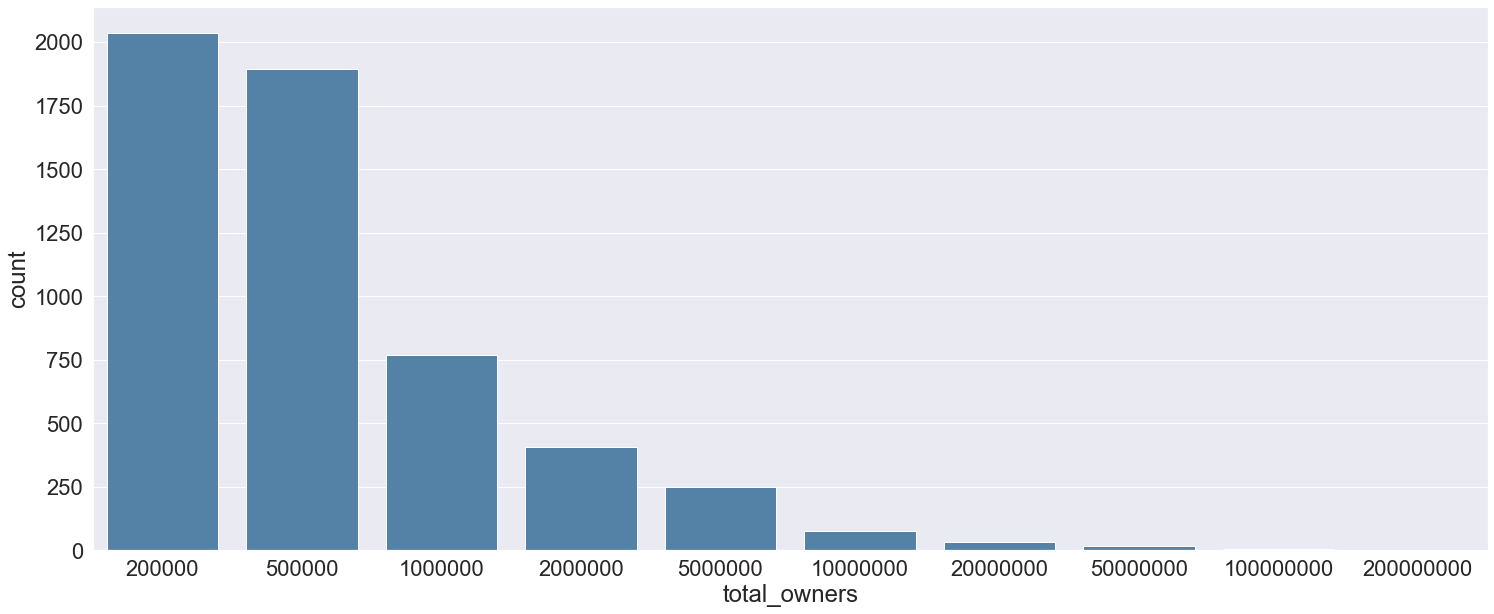

In [19]:
# Visualize total owners count
plt.figure(figsize=(25,10))
sns.countplot(x=df1['total_owners'],data=df1, color= 'steelblue')

### Top 10 Rated Games

In [20]:
df_games = df1[['name', 'release_year', 'average_playtime', 'total_owners', 'rating', 'price']]
display(df_games.sort_values(by = 'rating', ascending = False).head(10))

,name,release_year,average_playtime,total_owners,rating,price
23,Portal 2,2011,875,20000000,98.0,1.99
4186,Hades,2020,1767,10000000,98.0,24.99
2469,Stardew Valley,2016,3404,20000000,97.0,14.99
4220,Helltaker,2020,153,5000000,97.0,0.00
4027,Bloons TD 6,2018,2779,5000000,97.0,9.99
4126,Half-Life: Alyx,2020,642,5000000,97.0,59.99
4181,People Playground,2019,2139,5000000,97.0,9.99
17,Portal,2007,282,20000000,97.0,9.99
2584,Wallpaper Engine,2018,3407,20000000,97.0,3.99
2551,Factorio,2016,6144,10000000,97.0,30.00


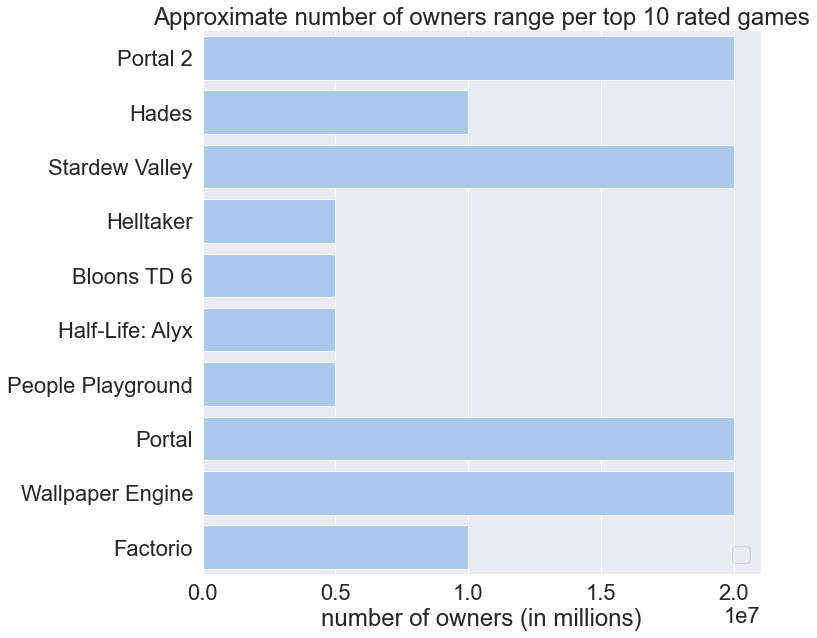

In [21]:
# over 1mil owners
df = df1[(df1.total_owners >= 1000000)].copy()

f, ax = plt.subplots(figsize=(10,10))

df_sorted_owners = df1.sort_values('rating', ascending=False).head(10)

sns.set_color_codes("pastel")
sns.barplot(x='total_owners', y="name", data=df_sorted_owners, color="b")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], ncol=2, loc="lower right", frameon=True)
ax.set(
    xlabel="number of owners (in millions)",
    ylabel="",
    title="Approximate number of owners range per top {} rated games".format(10)
)
sns.despine(left=True, bottom=True)

### Top 10 Most Owned Games

In [22]:
top_owned = display(df_games.sort_values(by = 'total_owners', ascending = False).head(10))

,name,release_year,average_playtime,total_owners,rating,price
22,Dota 2,2013,35483,200000000,84.0,0.00
19,Team Fortress 2,2007,9470,100000000,93.0,0.00
4172,New World,2021,9088,100000000,68.0,39.99
4128,PUBG: BATTLEGROUNDS,2017,21824,100000000,56.0,0.00
25,Counter-Strike: Global Offensive,2012,28940,100000000,88.0,0.00
4014,Among Us,2018,1226,50000000,91.0,4.99
4173,Destiny 2,2019,7857,50000000,83.0,0.00
1483,Brawlhalla,2017,2050,50000000,83.0,0.00
4208,Halo Infinite,2021,836,50000000,75.0,0.00
4209,ELDEN RING,2022,4308,50000000,87.0,59.99


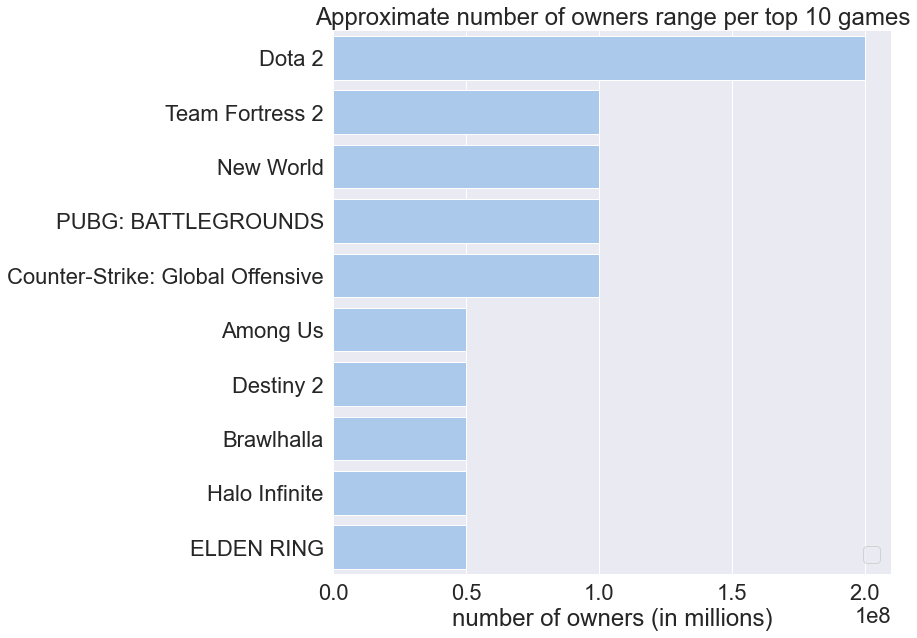

In [23]:
# Plot top 10 games by owners
f, ax = plt.subplots(figsize=(10,10))

df_sorted_owners = df1.sort_values('total_owners', ascending=False).head(10)

sns.set_color_codes("pastel")
sns.barplot(x='total_owners', y="name", data=df_sorted_owners, color="b")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], ncol=2, loc="lower right", frameon=True)
ax.set(
    xlabel="number of owners (in millions)",
    ylabel="",
    title="Approximate number of owners range per top {} games".format(10)
)
sns.despine(left=True, bottom=True)

### Top 10 Most Played Games

In [24]:
display(df_games.sort_values(by = 'average_playtime', ascending = False).head(10))

,name,release_year,average_playtime,total_owners,rating,price
4385,NGU IDLE,2019,120223,1000000,93.0,0.00
4354,Lords Mobile,2019,112846,1000000,67.0,0.00
3832,SAO Utils: Beta,2018,93530,500000,84.0,3.99
2800,Idling to Rule the Gods,2016,40974,500000,84.0,0.00
3738,Trailer Park Boys: Greasy Money,2018,40516,500000,77.0,0.00
3069,RutonyChat,2016,38274,200000,75.0,14.99
3958,Cadria Item Shop,2018,37855,500000,69.0,0.00
22,Dota 2,2013,35483,200000000,84.0,0.00
245,Hearts of Iron 2 Complete,2009,34494,200000,80.0,14.99
3181,Onmyoji,2018,31604,500000,79.0,0.00


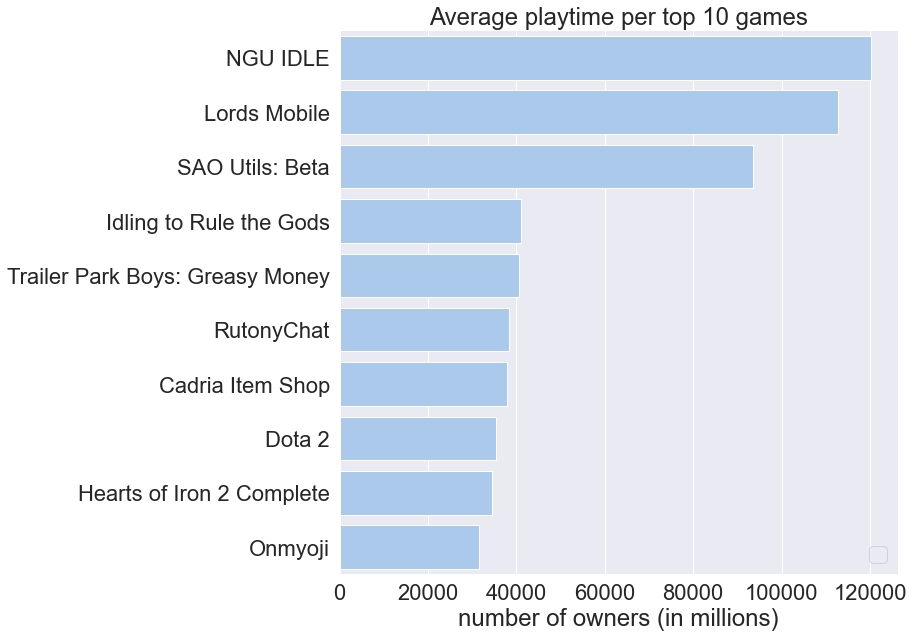

In [25]:
f, ax = plt.subplots(figsize=(10,10))

df_sorted_owners = df1.sort_values('average_playtime', ascending=False).head(10)

sns.set_color_codes("pastel")
sns.barplot(x='average_playtime', y="name", data=df_sorted_owners, color="b")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], ncol=2, loc="lower right", frameon=True)
ax.set(
    xlabel="number of owners (in millions)",
    ylabel="",
    title="Average playtime per top {} games".format(10)
)
sns.despine(left=True, bottom=True)

#### Which years had the highest playtime average?

<AxesSubplot:xlabel='release_year', ylabel='average_playtime'>

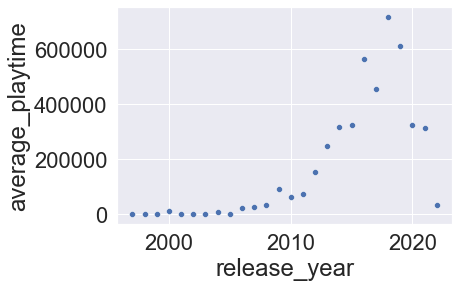

In [26]:
average_play = df_games.groupby(by = 'release_year').average_playtime.sum().sort_values(ascending = False)#.head(10)
average_play_df = pd.DataFrame(average_play)
sns.scatterplot(x='release_year', y='average_playtime', data=average_play_df)

In [27]:
df1.columns

Index(['type', 'name', 'appid', 'required_age', 'detailed_description',
       'about_the_game', 'short_description', 'linux_requirements',
       'platforms', 'categories', 'release_date', 'developer', 'publisher',
       'positive_ratings', 'negative_ratings', 'owners', 'average_playtime',
       'median_playtime', 'price', 'initialprice', 'discount', 'languages',
       'genre', 'ccu', 'tags', 'review_score', 'rating', 'owners_min',
       'total_owners', 'tags_cleaned', 'multiplayer', 'singleplayer',
       'pc_minimum', 'pc_recommended', 'mac_minimum', 'mac_recommended',
       'linux_minimum', 'linux_recommend', 'release_year', 'total_ratings',
       'max_revenue', 'min_revenue', 'over_1mil', 'game_attributes',
       'price_range'],
      dtype='object')

In [28]:
languages = fill_col(df1['languages'], ',')
languages[['name', 'release_year', 'average_playtime', 'total_owners', 'rating', 'languages']] = df1[['name', 'release_year', 'average_playtime', 'total_owners', 'rating', 'languages']]
first_column = languages.pop('name')
second_column = languages.pop('release_year')
languages.insert(0, 'name', first_column)
languages.insert(1,'release_year', second_column)

In [29]:
languages.columns

Index(['name', 'release_year', 'English', 'French', 'German', 'Italian',
       'Spanish-Spain', 'SimplifiedChinese', 'TraditionalChinese', 'Korean',
       'Russian', 'Dutch', 'Danish', 'Finnish', 'Japanese', 'Norwegian',
       'Polish', 'Portuguese', 'Swedish', 'Thai', 'Turkish', 'Czech',
       'Hungarian', 'Portuguese-Brazil', 'Greek', 'Bulgarian', 'Romanian',
       'Ukrainian', 'Spanish-LatinAmerica', 'Vietnamese', 'Slovakian',
       'Arabic', 'Unknown', 'Notsupported', 'average_playtime', 'total_owners',
       'rating', 'languages'],
      dtype='object')

,Number of Supported Languages
Languages,
English,5461
German,2944
French,2880
Spanish-Spain,2668
Russian,2488
Italian,2196
SimplifiedChinese,1963
Japanese,1794
Portuguese-Brazil,1497


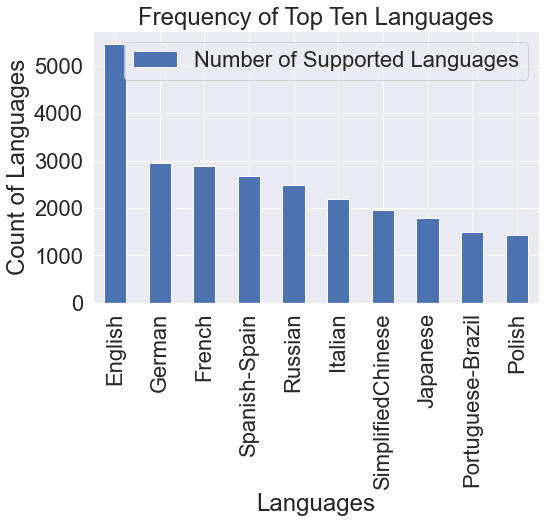

In [30]:
x = languages.iloc[:,2:-4]
x.columns

lang_type = x.columns
lang_total = []
for value in lang_type:
    lang_total.append(languages[languages[value] == 1]['name'].count())
    
lang_data = {'Number of Supported Languages': lang_total}
top_languages = pd.DataFrame(lang_data, index=lang_type)
top_languages.index.name = 'Languages'

# display number on chart
# data leakage?
lang_plot = top_languages.sort_values(by = 'Number of Supported Languages', ascending = False).head(10)
display(lang_plot)
ax = lang_plot.plot.bar(figsize=(8,5))
ax.set_ylabel('Count of Languages')
ax.set_xlabel('Languages')
ax.set_title('Frequency of Top Ten Languages')
plt.show()

## Platforms

In [31]:
def fill(df):
    df = df.str.replace(' ', '')
    col_dict = df.apply(lambda x: x.split(';')).apply(lambda y:{values: 1 for values in y}).values
    col_fill = pd.DataFrame(list(col_dict)).fillna(0)
    return col_fill

,Number of Supported Platforms
Platforms,
windows,5489
mac,2065
linux,1430


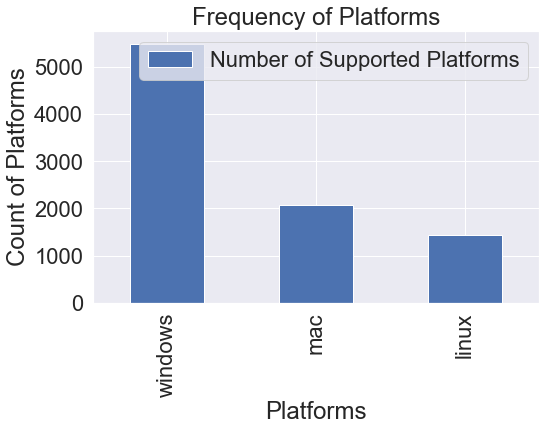

In [32]:
platforms = fill(df1['platforms'])
platforms[['name', 'release_year', 'average_playtime', 
           'total_owners', 'rating', 'platforms']] = df1[['name', 'release_year', 'average_playtime', 
                                                        'total_owners', 'rating', 'platforms']]
first_column = platforms.pop('name')
second_column = platforms.pop('release_year')
platforms.insert(0, 'name', first_column)
platforms.insert(1,'release_year', second_column)

x = platforms
x.columns[2:5]

platform_type = x.columns
platform_total = []
for value in platforms:
    platform_total.append(platforms[platforms[value] == 1]['name'].count())
    
platform_data = {'Number of Supported Platforms': platform_total}
top_platforms = pd.DataFrame(platform_data, index= platform_type)
top_platforms.index.name = 'Platforms'

# display number on chart
# data leakage?
platforms_plot = top_platforms.sort_values(by = 'Number of Supported Platforms', ascending = False).head(3)
display(platforms_plot)
ax = platforms_plot.plot.bar(figsize=(8,5))
ax.set_ylabel('Count of Platforms')
ax.set_xlabel('Platforms')
ax.set_title('Frequency of Platforms')
plt.show()

## Categorial vs. Numerical Variables

In [33]:
def make_scatterplot_feature(TARGET1, TARGET2):
    TARGET = TARGET1, TARGET2
    X_VALS = [x_col for x_col in NUM.columns if x_col != TARGET]
    
    for x in X_VALS:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,3))
        sns.scatterplot(x=x, y=TARGET1, data=NUM, ax=ax1)#.set(title=f'Price by {X_VALS}')
        sns.scatterplot(x=x, y=TARGET2, data=NUM, ax=ax2)
        # fig.tight_layout()
        plt.show()
    
    return 

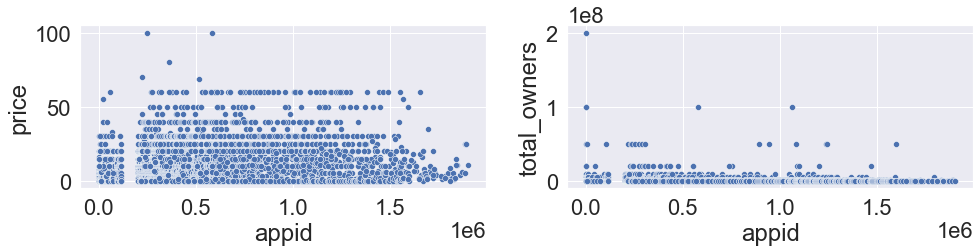

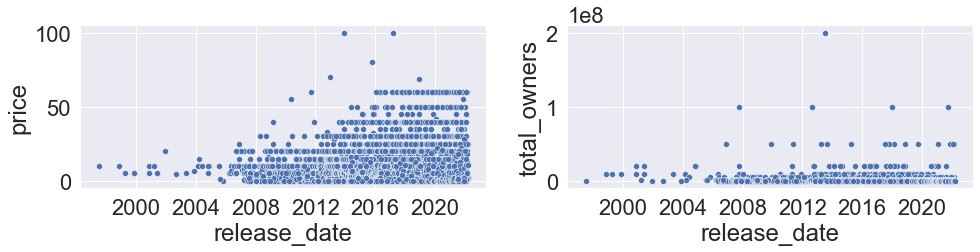

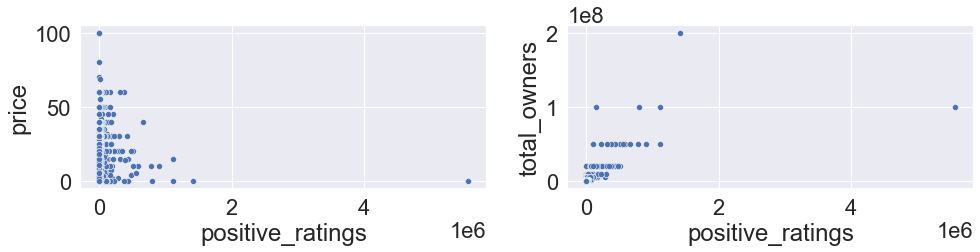

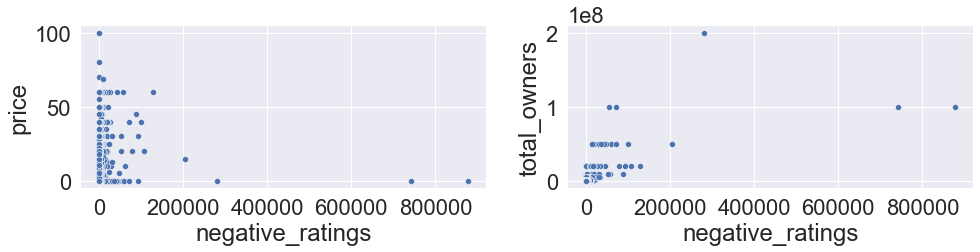

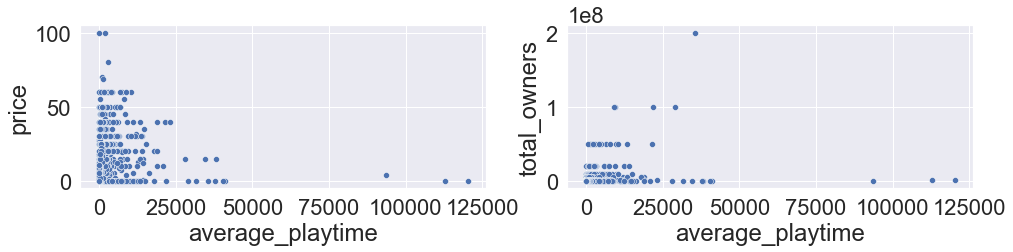

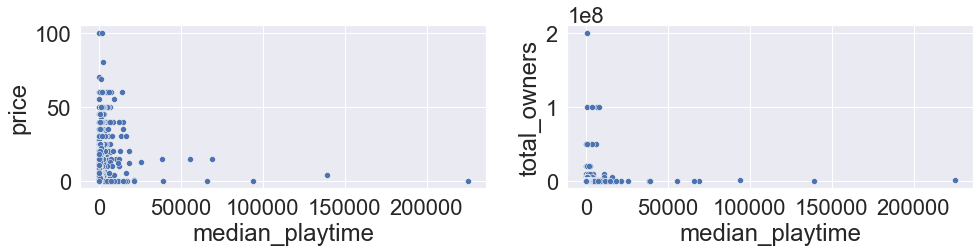

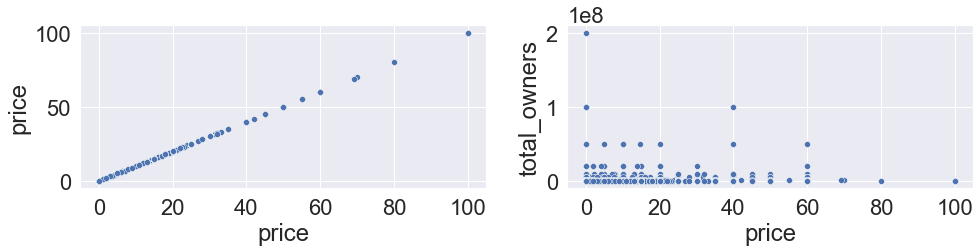

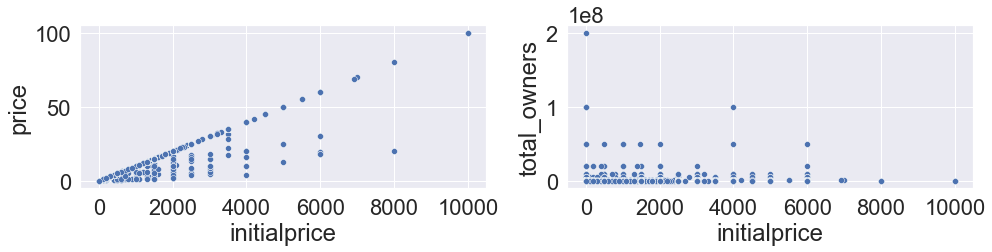

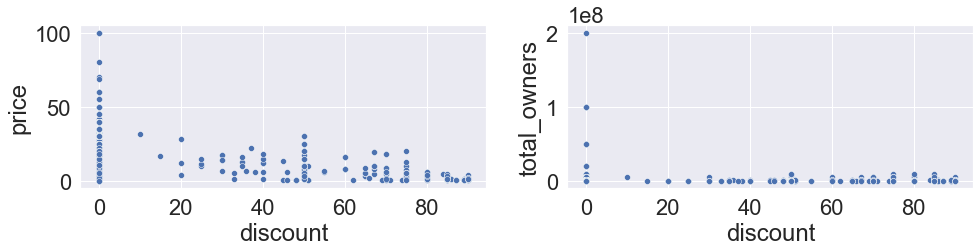

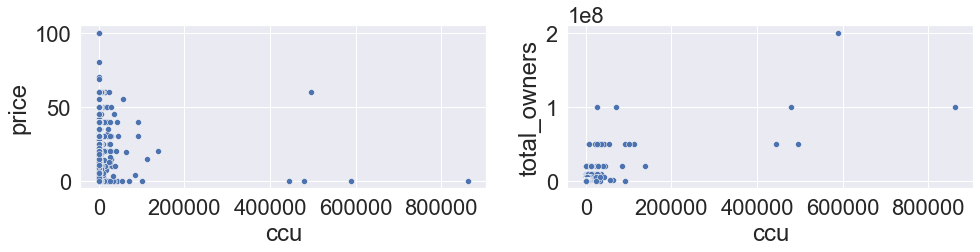

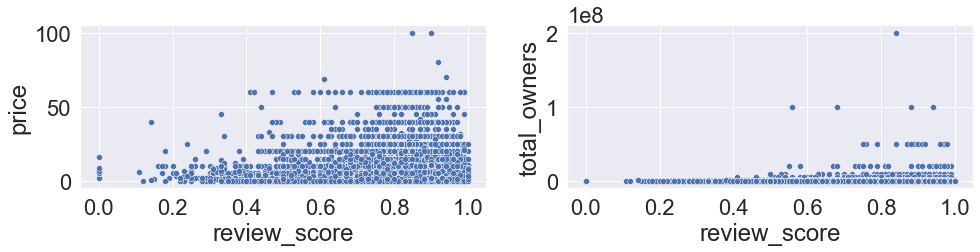

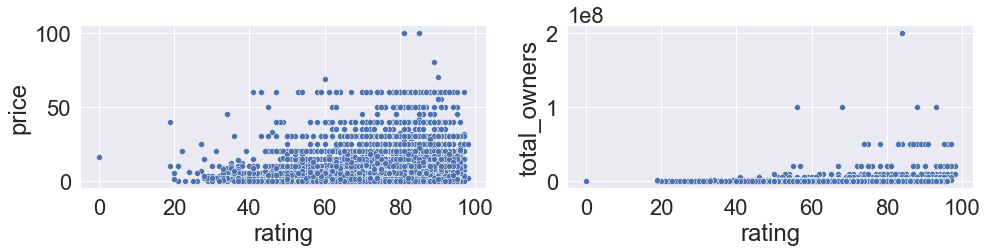

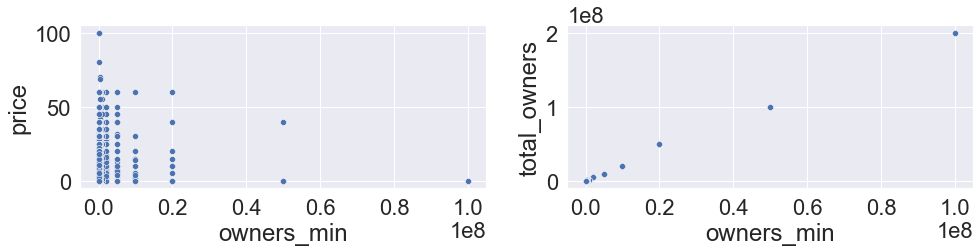

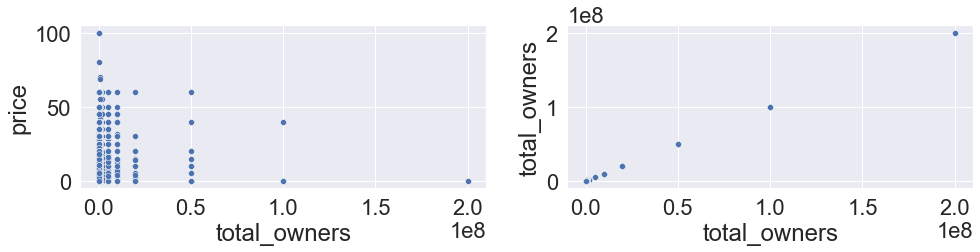

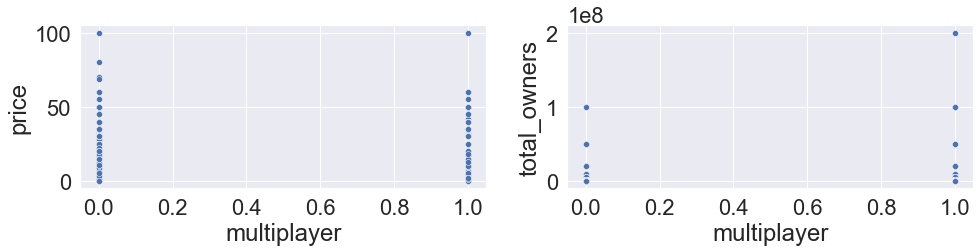

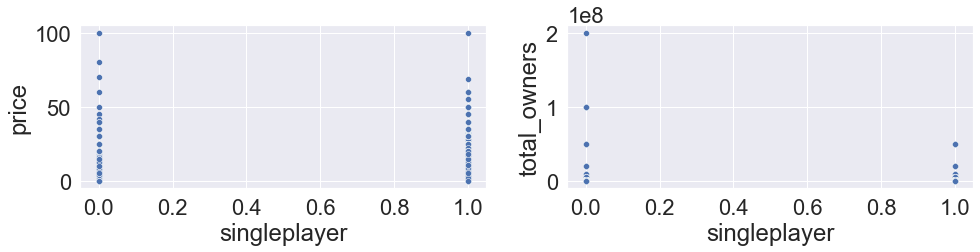

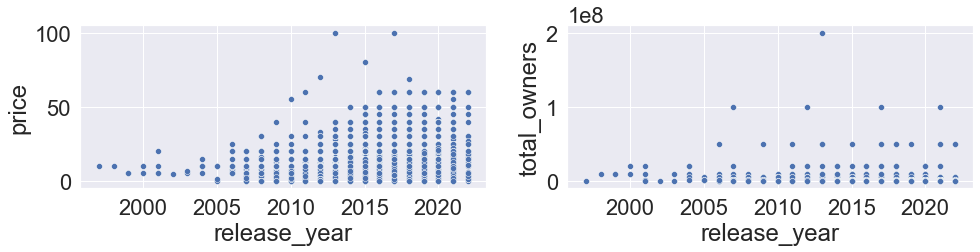

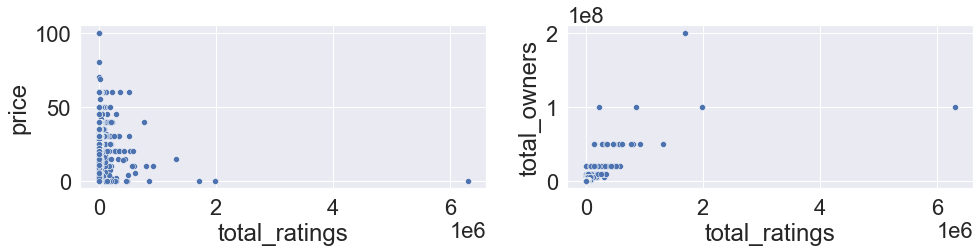

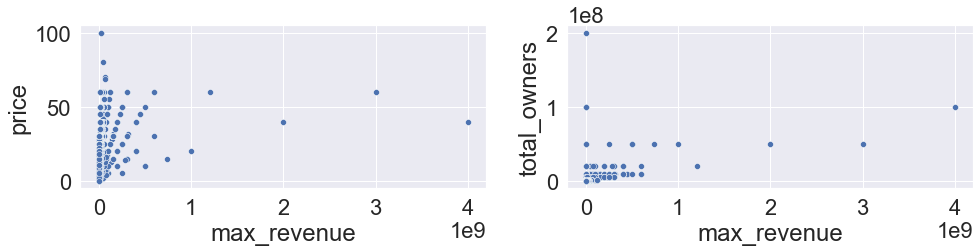

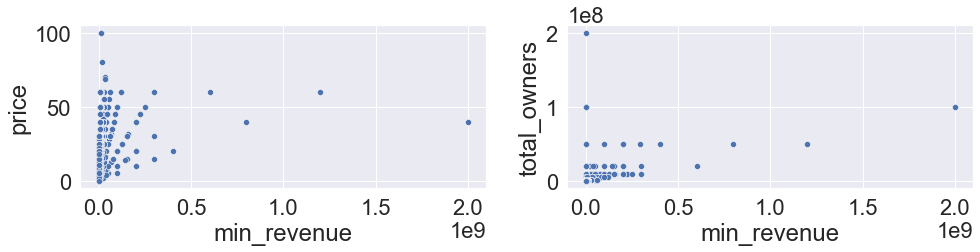

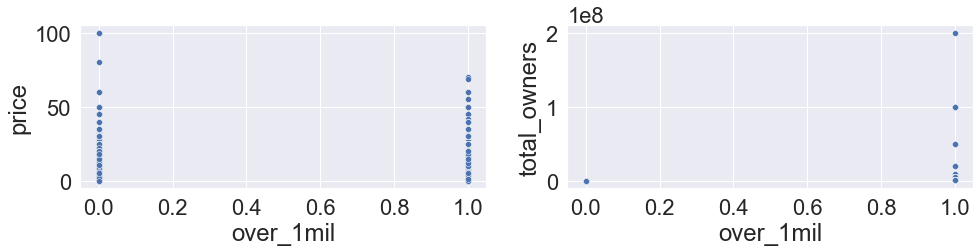

In [34]:
make_scatterplot_feature('price', 'total_owners')

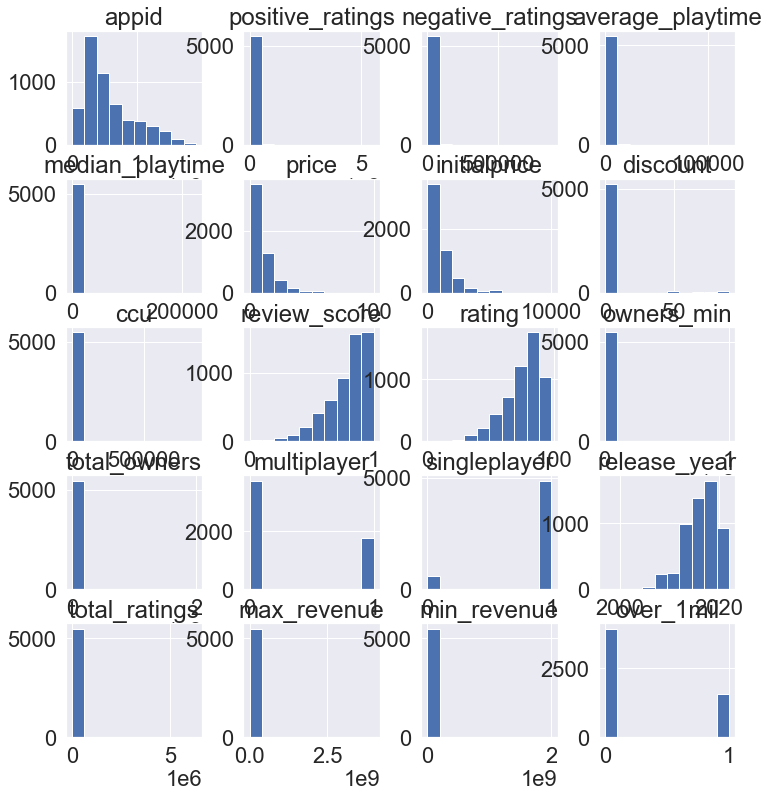

In [35]:
NUM.hist(figsize=(12,13));

## One Hot Encode

In [36]:
def platforms(df):
    """Create dummy variables for platforms"""
    platforms = df['platforms'].str.get_dummies(';')
    df = pd.concat([df,platforms], axis = 1)
    
    return df

def required_age(df):
    """ Create dummy variables for required age"""
    age = df['required_age'].str.get_dummies()
    df = pd.concat([df,age], axis = 1)
    
    return df

def price_range(df):
    """Create dummy variables for price range categories"""
    price = df['price_range'].str.get_dummies()
    df = pd.concat([df,price], axis = 1)
    
    return df

def game_attributes(df):
    """Clean and process Categories, Genres, and Tags using the game_attributes column"""

    game_attributes = df['game_attributes'].str.replace(';', ',').str.replace('-','').str.replace(', ', ',').str.replace(' ,', ',').str.replace('-','').str.replace(' ','_')
    game_attributes = game_attributes.str.get_dummies(',')
    col_names = game_attributes.mean()[game_attributes.mean() > 0.01].sort_values(ascending=False).keys()
    df = pd.concat([df,game_attributes[col_names]], axis=1)

    return df


In [37]:
def multi_label(df):
    
    df = df.copy()
    
    df = game_attributes(df)
    df = platforms(df) 
    df = required_age(df)
    df = price_range(df)
    
    df.drop(['categories', 'tags', 'tags_cleaned', 'genre'], axis=1, inplace = True)
    
    return df
    
df = multi_label(df1)

In [38]:
# df.to_csv('data/steam_preprocessed.csv', index=False)

In [39]:
for col in df.columns:
    print(col)

type
name
appid
required_age
detailed_description
about_the_game
short_description
linux_requirements
platforms
release_date
developer
publisher
positive_ratings
negative_ratings
owners
average_playtime
median_playtime
price
initialprice
discount
languages
ccu
review_score
rating
owners_min
total_owners
multiplayer
singleplayer
pc_minimum
pc_recommended
mac_minimum
mac_recommended
linux_minimum
linux_recommend
release_year
total_ratings
max_revenue
min_revenue
over_1mil
game_attributes
price_range
Singleplayer
Indie
Steam_Achievements
Action
Adventure
Steam_Trading_Cards
Multiplayer
Steam_Cloud
Casual
Strategy
RPG
Full_controller_support
Atmospheric
Simulation
Coop
2D
Great_Soundtrack
Story_Rich
Free_to_Play
Open_World
FirstPerson
Shooter
Funny
Puzzle
Partial_Controller_Support
Fantasy
Horror
Scifi
Difficult
FPS
Steam_Leaderboards
Survival
Third_Person
Early_Access
Exploration
Sandbox
Pixel_Graphics
Online_MultiPlayer
Anime
PvP
Female_Protagonist
Online_CoOp
Online_Coop
Gore
Comedy
Mas